# 1. Packages import

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
from textwrap import wrap
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pyodbc 


%matplotlib inline

# 2. Data retrieval

In [2]:
'''Connect to post result SQL server'''
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER=dsa-ln-WS015\SQLEXPRESS;DATABASE=Post_result;Trusted_Connection=yes')   
cursor = cnxn.cursor() 

In [3]:
def SQL_fundamentals(region):
    '''
    Grab the fundamental data from SQL database
    region= US, Europe,Asia,or Canada
    return the post result fundamental dataframe
    '''
    sql="select * from {0}".format(region)
    data=pd.read_sql(sql,cnxn).set_index("Ticker").drop_duplicates().replace('#N/A Invalid Security','')
    
    def SQL_fundamental_date_transform(SQL_date):
        '''
        Transform the SQL fundamental style string into dateframe string style
        '''
        timestamp=pd.Timestamp(int(SQL_date[:4]),
                            int(SQL_date[5:7]),
                            int(SQL_date[8:]))
        return timestamp
    
    data=data[data.index!='']
    data["Date"]=[SQL_fundamental_date_transform(i) for i in data["Date"]]
    data["ticker_copy"]=data.index
    data=data.sort_values(by=["ticker_copy","Date"])
    data["next_date"]=data["Date"].shift(-1)
    data["ticker_copy"]=data["ticker_copy"].shift(-1)
    data["Date"]=data["Date"].apply(lambda x: x.strftime("%d/%b/%Y") if x!='' else np.nan)
    data["Next"]=data.apply(lambda x: x["next_date"].strftime("%d/%b/%Y") if x.name==x["ticker_copy"] else np.nan,axis=1)

    del data["ticker_copy"]
    del data["next_date"]
     
    data.index=pd.MultiIndex.from_tuples(data.apply(lambda x:(x.name,x["Date"],x["Next"]),axis=1))
    
    for s in ["Revision","Market cap","Volume","EPS","Broker"]:
        data[s]=pd.to_numeric(data[s])
    
    
    return data

In [4]:
def SQL_price(region,start,end):
    '''
    Grab the pricing data from SQL database
    region= US, Europe,Asia,or Canada
    start,end are in year
    key is the reference to search
    return the target price dataframe with timestamp on the column
    '''
    mylist=[]
    for year in range(start,end+1):
        sql="select * from {0}_price_{1}".format(region,year)
        data=pd.read_sql(sql,cnxn).set_index("Ticker").drop_duplicates()
        adj_data=data.loc[[x for x in data.index if len(x)>0]].replace('#N/A N/A','')
        mylist.append(adj_data)

    price=pd.concat(mylist,axis=1)
    price=price.apply(lambda x:pd.to_numeric(x),axis=1)
    
    
    def SQL_price_date_transform(SQL_date):
        '''
        Transform the SQL price style string into dateframe string style
        '''
        timestamp=pd.Timestamp(int(SQL_date[SQL_date.find(" ",3):]),
                            int(SQL_date[:SQL_date.find(" ")]),
                            int(SQL_date[SQL_date.find(" ",1):SQL_date.find(" ",3)]))
        return timestamp.strftime("%d/%b/%Y")
    
    price.columns=[SQL_price_date_transform(i) for i in price.columns]
    return price

In [12]:
US=SQL_fundamentals("US")
US_price=SQL_price('US',2006,2017)

# 3. Utility functions

In [5]:
def EAR_calc(ticker,date,return_df,EAR_period,vol_lookback):
    '''
    Calculate EAR from ticker and reference date
    '''
    if type(date)==pd._libs.tslib.NaTType:
        return None
    elif type(date)==pd._libs.tslib.Timestamp:
        date=date.strftime("%d/%b/%Y")
    elif type(date)==str:
        date=date
    return_series=return_df.loc[ticker].dropna()
    date_series=return_series.index.tolist()
    if date in date_series:
        day0=date_series.index(date)
        post_series=return_series.iloc[day0:]
        pre_series=return_series.iloc[:day0]
        vol= return_series.iloc[day0-min(len(pre_series),vol_lookback+1):day0].std()
        ret=(return_series.iloc[day0:day0+EAR_period]+1).prod()-1
        nmove=ret/vol
        return nmove
    else:
        return None

In [6]:
def signal_vol(signal_column,return_df,vol_lookback):
    '''
    Calculate simple vol from signal tuple
    '''
    signal_series=return_df.loc[signal_column.name[0]]
    location=signal_series.index.tolist().index(signal_column.name[1])
    vol_range=min(vol_lookback,len(signal_series[:location]))
    signal_vol=signal_series[location-vol_range-1:location].std()
    return signal_vol

In [7]:
def slice_universe(signal_df,start_datetime,end_datetime):
    '''
    Slice the signal_df, both the index and entry date have to be 
    '''
    
    entry=signal_df.apply(lambda x:datetime.strptime(x.name[1],"%d/%b/%Y"),axis=0)
    period_evaluate=(entry>=start_datetime)&(entry<=end_datetime)
    adj_signal_df=signal_df.loc[:,period_evaluate]
    adj_signal_df=adj_signal_df.loc[start_datetime:end_datetime]
    
    zero_index=pd.date_range(start_datetime,end_datetime,freq='B').to_frame()
    adj_signal_df=pd.concat([adj_signal_df,zero_index],axis=1).iloc[:,:-1]
    return adj_signal_df
    

In [9]:
def signal_filter_stop(signal_df,stop_level,return_df,vol_lookback):
    '''
    Input - signal_df
    Get the updated signal df after the stop loss
    '''
    
    vol_row=signal_df.apply(lambda column:signal_vol(column,return_df,vol_lookback),axis=0)
    signal_cum_nmove=((1+signal_df).cumprod()-1).ffill()/vol_row
    signal_df_stop=signal_df[-(signal_cum_nmove.expanding().min().shift(1,axis=0)<-stop_level)]
    return signal_df_stop

In [10]:
def sizing(signal_df,reference,gross,fundamental_df,return_df,risk_parity,liquidity,capital):
    '''
    Use historical signal_df range to calculate the size row for the current signal_df range
    Idea is to use historical as a benchmark for future sizing
    '''
    number=reference.count(axis=1).mean()
    avg_size=gross/100/number
    vol_reference=reference.apply(lambda column:signal_vol(column,return_df,30),axis=0).mean()
    vol_row=signal_df.apply(lambda column:signal_vol(column,return_df,30),axis=0)
    
    fundamental_df=fundamental_df.sort_index()
    if risk_parity is True:
        size_row=signal_df.apply(lambda x: min(avg_size/(vol_row[x.name]/vol_reference),\
                                               fundamental_df.loc[x.name[0],x.name[1]]["Volume"].iloc[0]*\
                                               liquidity/capital),axis=0)
    else:
        size_row=signal_df.apply(lambda x: min(avg_size, fundamental_df.loc[x.name[0],x.name[1]]["Volume"].iloc[0]\
                                               *liquidity/capital),axis=0)
    return size_row

In [19]:
def trading_analytics_date(portfolio_cache):
    '''
    Key portfolio metrics from portfolio cache
    Feed into plot function
    '''
    
    ind_return=portfolio_cache[3]
    signal_count=len(ind_return)
    account_curve=portfolio_cache[1]
    
    if signal_count==0:
        return None,None,None,None,None,None,None
    else:
        mean_return=ind_return.mean()
        hit_rate=len(ind_return[ind_return>0])/len(ind_return)*1.0
        payoff_ratio=ind_return[ind_return>0].mean()/ind_return[ind_return<0].mean()*-1.0
        
        account_price=account_curve+1
        ann_vol=np.std(account_price.diff()/account_price.shift(1))*(260**0.5)
        ann_ret=np.mean(account_price.diff()/account_price.shift(1))*260
        ann_sharpe=ann_ret/ann_vol
        
        max_dd=-((1+account_curve)/(1+account_curve).cummax(axis=0)-1).expanding().min().min()
        
        #low_date=(np.maximum.accumulate(account_curve)-account_curve).idxmax()
        #high_date=account_curve[:low_date].idxmax()
        #max_dd=1-(1+account_curve[low_date])/(1+account_curve[high_date])
        
        return signal_count,hit_rate,payoff_ratio,ann_ret,ann_vol,ann_sharpe,max_dd

# 4. Signal class 

In [40]:
class signal(object):
    '''
    Signal class is built to initialize the signal_df and account curve from base parameters 
    '''
    def __init__(self,fundamental_df,price_df,EAR_period,long_criteria,short_criteria,holding,start,end,\
                long_size=None,short_size=None):
        '''
        Define the key free parameters of the signal
        Criteria:(EAR_low,EAR_high,revision_low,revision_high,size_low,size_high)
        '''
        self.fundamental_df=fundamental_df
        self.price_df=price_df
        self.abs_return=price_df.diff(1,axis=1)/price_df.shift(1,axis=1)
        self.EAR_period=EAR_period
        self.long_criteria=long_criteria
        self.short_criteria=short_criteria
        self.holding=holding
        self.start=start
        self.end=end
        self.long_size=long_size
        self.short_size=short_size
        
    def signal_base(self):
        '''
        Filter the EAR and revision, get the target signal list
        For both long and short side
        '''
        
        if self.long_criteria is None:
            long_base=None
        else:
            
            target_long=self.fundamental_df[(self.fundamental_df["Revision"]>self.long_criteria[2])\
                                                &(self.fundamental_df["Revision"]<self.long_criteria[3])]

            if self.long_size is None:
                pass
            else:
                target_long=target_long[(target_long["Market cap"]>self.long_size[0])&\
                                        (target_long["Market cap"]<self.long_size[1])]

            target_long["EAR"]=target_long.apply(lambda x:EAR_calc(x.name[0],x.name[1],self.abs_return,self.EAR_period,30)\
                                         if x.name[0] in self.abs_return.index else None,axis=1)
            
            long_base=target_long[(target_long["EAR"]>self.long_criteria[0])&(target_long["EAR"]<self.long_criteria[1])]
            
        if self.short_criteria is None:
            short_base=None
        else:
            
            target_short=self.fundamental_df[(self.fundamental_df["Revision"]>self.short_criteria[2])\
                                                &(self.fundamental_df["Revision"]<self.short_criteria[3])]

            if self.short_size is None:
                pass
            else:
                target_short=target_short[(target_short["Market cap"]>self.short_size[0])&\
                                          (target_short["Market cap"]<self.short_size[1])]

            target_short["EAR"]=target_short.apply(lambda x:EAR_calc(x.name[0],x.name[1],self.abs_return,self.EAR_period,30)\
                                         if x.name[0] in self.abs_return.index else None,axis=1)
            
            short_base=target_short[(target_short["EAR"]>self.short_criteria[0])&(target_short["EAR"]<self.short_criteria[1])]
        return long_base,short_base
    
    def signal_df_date(self):#if we hold them through next earning
        '''
        Obtain the signal_df function over the whole time period
        '''
        long_base,short_base=signal.signal_base(self)
        
        if long_base is None:
            long_df=None
        
        else:
            long_df=pd.DataFrame(index=self.price_df.columns)

            for s in long_base.index:
                return_series=self.abs_return.loc[s[0]]
                if s[1] in return_series.index:
                    if not np.isnan(return_series.loc[s[1]]): 
                        day0=return_series.index.tolist().index(s[1])
                        if type(s[2])==float:##basically np.nan has type float
                            period=self.holding
                        else: ##assume that we are not holding through numbers
                            period=min(self.holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y"),\
                                                                    datetime.strptime(s[2],"%d/%b/%Y"))-self.EAR_period)\
                            #EAR period as entry
                        target_series=return_series.iloc[day0+self.EAR_period-1:day0+min(period+self.EAR_period, \
                                                                                       len(return_series[day0:]))].dropna()
                        if len(target_series)==0:
                            pass
                        else:
                            target_series.iloc[0]=0.0
                            long_df[s]=target_series                        

            long_df=long_df.reindex(datetime.strptime(i,"%d/%b/%Y") for i in long_df.index)

            if self.start is not None:
                long_df=slice_universe(long_df,self.start,self.end)
            else:
                pass
        
        if short_base is None:
            short_df=None
        
        else:
            short_df=pd.DataFrame(index=self.price_df.columns)

            for s in short_base.index:
                return_series=self.abs_return.loc[s[0]]
                if s[1] in return_series.index:
                    if not np.isnan(return_series.loc[s[1]]): 
                        day0=return_series.index.tolist().index(s[1])
                        if type(s[2])==float:##basically np.nan has type float
                            period=self.holding
                        else: ##assume that we are not holding through numbers
                            period=min(self.holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y"),\
                                                                    datetime.strptime(s[2],"%d/%b/%Y"))-self.EAR_period)\
                            #EAR period as entry
                        target_series=return_series.iloc[day0+self.EAR_period-1:day0+min(period+self.EAR_period, \
                                                                                       len(return_series[day0:]))].dropna()
                        if len(target_series)==0:
                            pass
                        else:
                            target_series.iloc[0]=0.0
                            short_df[s]=target_series                        

            short_df=short_df.reindex(datetime.strptime(i,"%d/%b/%Y") for i in short_df.index)

            if self.start is not None:
                short_df=slice_universe(short_df,self.start,self.end)
            else:
                pass        
        
        long_df=long_df.dropna(how="all",axis=1)
        short_df=short_df.dropna(how="all",axis=1)
        
        self.long_df=long_df
        self.short_df=short_df
        
        return long_df,short_df

    def signal_account(self,stop,gross,index_df,net_level,risk_parity,liquidity,capital):
        '''
        Build the account curve with signal_df
        Assume quarterly rebalancing that's why the period list has quarter as the key
        Take extra care when building the account curve, the logic is: work out the size_df, then shift by 1 and * signal_df
        Stop=(long_stop,short_stop)
        '''
        
        try:
            long_df=self.long_df
            short_df=self.short_df
            
        except AttributeError:
            long_df,short_df=signal.signal_df_date(self)
                   
        '''
        Assign values for later use
        '''
        self.stop=stop
        self.gross=gross
        self.index_df=index_df
        self.net_level=net_level
        self.risk_parity=risk_parity
        self.liquidity=liquidity
        self.capital=capital
        
        
        '''
        Define rebalance period first
        '''
        period=long_df.apply(lambda x:str(x.name.year)+" "+str(x.name.quarter),axis=1)
        period_list=list(set(period))
        period_list.sort()    
        
        '''
        Separate out long and short
        '''
        if long_df is None:
            long_cache=(None,None,None,None)
        else:
            if stop is None:
                pass
            else:
                long_df=signal_filter_stop(long_df,stop[0],self.abs_return,30)   

            long_sub_signal={}
            long_sub_size_row={}
            long_sub_size_df={}
            long_sub_pnl={}
        
            for s in period_list:
                long_sub_signal[s]=long_df[period==s].dropna(how='all',axis=1)
                if period_list.index(s)<4:##use last quarter's sizing as reference
                    long_sub_size_row[s]=sizing(long_sub_signal[s],long_sub_signal[s],gross[0],self.fundamental_df,\
                                                   self.abs_return,risk_parity,liquidity,capital)
                else:
                    long_sub_size_row[s]=sizing(long_sub_signal[s],long_sub_signal[period_list[period_list.index(s)-1]],\
                                                   gross[0],self.fundamental_df,self.abs_return,risk_parity,liquidity,capital)
                long_sub_size_df[s]=(1+long_sub_signal[s]).cumprod()*long_sub_size_row[s]
                long_sub_pnl[s]=(long_sub_size_df[s].shift(1))*long_sub_signal[s] 
                # need to shift by 1 as the size is end of the day
        
            long_daily_pnl=pd.concat(list(long_sub_pnl.values()),axis=0)
            long_acct_curve=long_daily_pnl.cumsum().ffill().sum(axis=1)
            long_size_df=pd.concat(list(long_sub_size_df.values()),axis=0)
            long_ind_return=long_daily_pnl.cumsum().ffill().iloc[-1].dropna()
            long_cache=(long_daily_pnl,long_acct_curve,long_size_df,long_ind_return)

            
        if short_df is None:
            short_cache=(None,None,None,None)
        else:
            if stop is None:
                pass
            else:
                short_df=-signal_filter_stop(-short_df,stop[1],self.abs_return,30)   

            short_sub_signal={}
            short_sub_size_row={}
            short_sub_size_df={}
            short_sub_pnl={}
        
            for s in period_list:
                short_sub_signal[s]=short_df[period==s].dropna(how='all',axis=1)
                if period_list.index(s)<4:##use last quarter's sizing as reference
                    short_sub_size_row[s]=-sizing(short_sub_signal[s],short_sub_signal[s],gross[1],self.fundamental_df,\
                                                   self.abs_return,risk_parity,liquidity,capital)
                else:
                    short_sub_size_row[s]=-sizing(short_sub_signal[s],short_sub_signal[period_list[period_list.index(s)-1]],\
                                                   gross[1],self.fundamental_df,self.abs_return,risk_parity,liquidity,capital)
                short_sub_size_df[s]=(1+short_sub_signal[s]).cumprod()*short_sub_size_row[s]
                short_sub_pnl[s]=(short_sub_size_df[s].shift(1))*short_sub_signal[s] 
                # need to shift by 1 as the size is end of the day
        
            short_daily_pnl=pd.concat(list(short_sub_pnl.values()),axis=0)
            short_acct_curve=short_daily_pnl.cumsum().ffill().sum(axis=1)
            short_size_df=pd.concat(list(short_sub_size_df.values()),axis=0)
            short_ind_return=short_daily_pnl.cumsum().ffill().iloc[-1].dropna()
            
            short_cache=(short_daily_pnl,short_acct_curve,short_size_df,short_ind_return)
    
        '''Put alpha positions together to form the alpha part'''
        alpha_df=pd.concat([long_df,short_df],axis=1)
        self.alpha_df=alpha_df
        
        alpha_daily_pnl=pd.concat([long_cache[0],short_cache[0]],axis=1)
        alpha_acct_curve=alpha_daily_pnl.cumsum().ffill().sum(axis=1)
        alpha_size_df=pd.concat([long_cache[2],short_cache[2]],axis=1)
        alpha_ind_return=pd.concat([long_cache[3],short_cache[3]],axis=0)
        
        alpha_cache=(alpha_daily_pnl,alpha_acct_curve,alpha_size_df,alpha_ind_return)
        
        
        if index_df is not None:
            index_df=alpha_df.join(index_df).iloc[:,-1]
            
            index_size_df=net_level-alpha_size_df.sum(axis=1)
            index_daily_pnl=index_size_df.shift(1)*index_df
            index_acct_curve=index_daily_pnl.cumsum()
            index_ind_return=index_acct_curve.iloc[-1]
            index_cache=(index_daily_pnl,index_acct_curve,index_size_df,index_ind_return)
        else:
            index_cache=(None,None,None,None)
            
        '''Finally put everything together'''    
        portfolio_df=alpha_df.join(index_df)
        
        portfolio_size_df=pd.concat([alpha_cache[2],index_cache[2]],axis=1)
        portfolio_daily_pnl=pd.concat([alpha_cache[0],index_cache[0]],axis=1)
        portfolio_acct_curve=portfolio_daily_pnl.cumsum().ffill().sum(axis=1)
        portfolio_ind_return=alpha_cache[3]
        
        portfolio_gross=np.abs(portfolio_size_df).sum(axis=1)
        portfolio_turnover=(np.abs(alpha_size_df.fillna(0.0).diff(1)).sum().sum())/(portfolio_size_df.shape[0]/260)
        
        portfolio_cache=(portfolio_daily_pnl,portfolio_acct_curve,portfolio_size_df,portfolio_ind_return,portfolio_gross,\
                         portfolio_turnover)
        
        self.portfolio_account=portfolio_cache #save for later use
        
        return long_cache,short_cache,alpha_cache,portfolio_cache
    
    def plot_account(self,title,figsize=[6,4]):
        '''
        Plot the account curve
        '''
        try:
            portfolio_cache=self.portfolio_account
            
        except AttributeError:
            print("Execute the signal_account first!")  
            return None        
        
        account_curve=portfolio_cache[1]
        avg_size=np.abs(portfolio_cache[2]).mean(axis=0).mean()
        ind_return=portfolio_cache[3]
        gross=portfolio_cache[4]
        turnover=portfolio_cache[5]
        
        fig=plt.figure(figsize=figsize)
        ax1=fig.add_subplot(1,1,1)
        ln1=ax1.plot(account_curve,label='signal',color='b')

        val1=ax1.get_yticks()
        start=val1[0]
        end=val1[-1]
        ax1.set_yticks(np.arange(start,end,0.1))  
        adj_val1=ax1.get_yticks()
        ax1.set_yticklabels(["{:.0%}".format(x) for x in adj_val1])

        ax2=ax1.twinx()
        ln2=ax2.plot(gross,label='gross',color='silver')

        val2=ax2.get_yticks()
        start=val2[0]
        end=val2[-1]
        ax2.set_yticks(np.arange(start,end,0.1))  
        adj_val2=ax2.get_yticks()
        ax2.set_yticklabels(["{:.0%}".format(x) for x in adj_val2])

        count,hit,payoff,ret,vol,sharpe,max_dd=trading_analytics_date(portfolio_cache)

        plt.title("\n".join(wrap('count='+str(count)+
                                 ',avg_size='+str("{:.1%}".format(avg_size))+
                                 ',hit_rate='+str("{:.0%}".format(hit))+
                                 ',payoff='+str(round(payoff,1))+
                                 ',return='+str("{:.1%}".format(ret))+
                                 ',vol='+str("{:.1%}".format(vol))+
                                 ',sharpe='+str(round(sharpe,1))+
                                 ',turnover='+str(round(turnover,1))+'x'+                             
                                 ',max_drawdown='+str("{:.1%}".format(max_dd)))),fontsize=10)

        ax1.set_xlabel('Year')
        ax1.set_ylabel('Return')
        ax2.set_ylabel('Exposure')
        plt.suptitle(title,y=1.05,fontsize=16)
        plt.grid(linestyle='dashed')
        plt.legend(ln1+ln2,[l.get_label() for l in ln1+ln2])
        ax1.axhline(y=0,color='k')

        plt.show()        
        

In [41]:
US_day2_30d=signal(fundamental_df=US,
                   price_df=US_price,
                   EAR_period=2,
                   long_criteria=(1,1000,0.05,1000),
                   short_criteria=(-1000,-2,-1000,-0.03),
                   holding=30,
                   start=pd.Timestamp(2007,1,1),
                   end=pd.Timestamp(2017,12,31),
                   long_size=None,
                   short_size=(5000,200000))

In [42]:
_long,_short,_alpha,_portfolio=US_day2_30d.signal_account(stop=None,
                                                           gross=(30,15),
                                                           index_df=abs_return_US.loc["SPX Index"],
                                                           net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.1,
                                                           capital=100)

C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


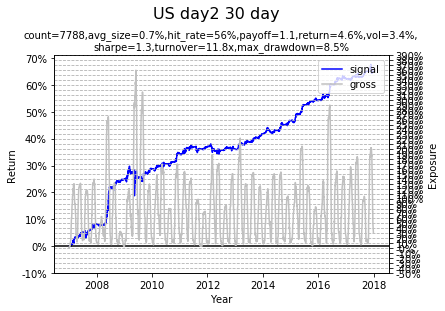

In [43]:
US_day2_30d.plot_account("US day2 30 day")